In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set up chart style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TweetAnalysis_Classification") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")


Spark Version: 3.5.0
Available cores: 20


In [3]:
# Load topic analysis and sentiment analysis data
print("=== Data Loading ===")

# Attempting to load topic analysis results
topic_data_path = "/home/jovyan/work/data/processed/topic_analyzed_comments.parquet"

try:
    df_topic = spark.read.parquet(topic_data_path)
    df_topic.cache()
    record_count = df_topic.count()
    print(f"✅ Topic analysis data loaded successfully, total {record_count:,} records")
    
    print("\nData structure:")
    df_topic.printSchema()
    
    # Check required columns
    required_cols = ['sentiment_label', 'cleaned_body', 'dominant_topic']
    missing_cols = [col for col in required_cols if col not in df_topic.columns]
    
    if missing_cols:
        print(f"❌ Missing required columns: {missing_cols}")
        print("Attempting to load alternative data sources...")
        
        # Alternative: load sentiment analysis data
        sentiment_data_path = "/home/jovyan/work/data/processed/sentiment_analyzed_comments.parquet"
        df_sentiment = spark.read.parquet(sentiment_data_path)
        
        # Need to re-perform sentiment classification
        def classify_sentiment(score):
            if score is None:
                return "Unknown"
            elif score > 0.1:
                return "Positive"
            elif score < -0.1:
                return "Negative"
            else:
                return "Neutral"
        
        classify_sentiment_udf = F.udf(classify_sentiment, StringType())
        
        # Find sentiment score columns
        sentiment_col = None
        for col in ['compound_score', 'vader_compound', 'sentiment']:
            if col in df_sentiment.columns:
                sentiment_col = col
                break
        
        if sentiment_col:
            df_topic = df_sentiment.withColumn(
                "sentiment_label",
                classify_sentiment_udf(F.col(sentiment_col))
            )
            df_topic = df_topic.withColumn("dominant_topic", F.lit(0))  # Temporary topic
            record_count = df_topic.count()
            print(f"✅ Using sentiment analysis data, total {record_count:,} records")
        else:
            raise Exception("Sentiment score column not found")
    else:
        print("✅ All required columns exist")
        
except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print("Using cleaned data as fallback...")
    
    # Final fallback: using cleaned data
    cleaned_data_path = "/home/jovyan/work/data/processed/cleaned_comments.parquet"
    df_base = spark.read.parquet(cleaned_data_path)
    
    # Using original sentiment column
    def classify_sentiment(score):
        if score is None:
            return "Unknown"
        elif score > 0.1:
            return "Positive"
        elif score < -0.1:
            return "Negative"
        else:
            return "Neutral"
    
    classify_sentiment_udf = F.udf(classify_sentiment, StringType())
    
    df_topic = df_base.withColumn(
        "sentiment_label",
        classify_sentiment_udf(F.col("sentiment"))
    ).withColumn("dominant_topic", F.lit(0))  # Temporary topic
    
    record_count = df_topic.count()
    print(f"✅ Using cleaned data, total {record_count:,} records")


=== Data Loading ===
❌ Data loading failed: [PATH_NOT_FOUND] Path does not exist: file:/home/jovyan/work/data/processed/topic_analyzed_comments.parquet.
Using cleaned data as fallback...
✅ Using cleaned data, total 459,171 records


In [4]:
# Data preprocessing and feature engineering
print("=== Data Preprocessing and Feature Engineering ===")

# 1. Check sentiment label distribution
print("1. Sentiment label distribution:")
sentiment_dist = df_topic.groupBy("sentiment_label").count().orderBy(F.desc("count"))
sentiment_dist.show()

# Convert to pandas to view detailed proportions
sentiment_dist_pd = sentiment_dist.toPandas()
total_count = sentiment_dist_pd['count'].sum()
sentiment_dist_pd['percentage'] = (sentiment_dist_pd['count'] / total_count * 100).round(2)

print("Detailed distribution:")
for _, row in sentiment_dist_pd.iterrows():
    label = row['sentiment_label']
    count = int(row['count'])
    pct = row['percentage']
    print(f"  {label}: {count:,} ({pct}%)")

# 2. Filter out "Unknown" label data (if exists)
df_filtered = df_topic.filter(F.col("sentiment_label") != "Unknown")
filtered_count = df_filtered.count()
print(f"\nData size after filtering: {filtered_count:,} records")

# 3. Check if tokenization results exist, if not re-tokenize
if 'tokens_cleaned' not in df_filtered.columns:
    print("3. Re-performing text tokenization...")
    from pyspark.ml.feature import Tokenizer, StopWordsRemover
    
    # Tokenization
    tokenizer = Tokenizer(inputCol="cleaned_body", outputCol="tokens_raw")
    df_tokens = tokenizer.transform(df_filtered)
    
    # Remove stop words
    remover = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens_cleaned")
    df_filtered = remover.transform(df_tokens)
    print("   Tokenization completed")
else:
    print("3. ✅ Tokenization results already exist")

print(f"\nFinal data for modeling: {df_filtered.count():,} records")


=== Data Preprocessing and Feature Engineering ===
1. Sentiment label distribution:
+---------------+------+
|sentiment_label| count|
+---------------+------+
|       Negative|205850|
|       Positive|201235|
|        Neutral| 47179|
|        Unknown|  4907|
+---------------+------+

Detailed distribution:
  Negative: 205,850 (44.83%)
  Positive: 201,235 (43.83%)
  Neutral: 47,179 (10.27%)
  Unknown: 4,907 (1.07%)

Data size after filtering: 454,264 records
3. ✅ Tokenization results already exist

Final data for modeling: 454,264 records


In [5]:
# Build feature vectors
print("=== Building Feature Vectors ===")

from pyspark.ml.feature import CountVectorizer, IDF

# 1. Text features: TF-IDF vectorization
print("1. Building TF-IDF features...")

# CountVectorizer
count_vectorizer = CountVectorizer(
    inputCol="tokens_cleaned", 
    outputCol="raw_features",
    vocabSize=3000,  # Reduce feature dimensions to improve training speed
    minDF=3.0        # Minimum document frequency
)

count_model = count_vectorizer.fit(df_filtered)
df_vectorized = count_model.transform(df_filtered)

# TF-IDF
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")
idf_model = idf.fit(df_vectorized)
df_tfidf = idf_model.transform(df_vectorized)

print(f"   TF-IDF vocabulary size: {len(count_model.vocabulary)}")

# 2. Topic feature processing (simplified to avoid OneHotEncoder issues)
if 'dominant_topic' in df_tfidf.columns:
    print("2. Processing topic features...")
    # Check uniqueness of topic values
    unique_topics = df_tfidf.select("dominant_topic").distinct().count()
    print(f"   Found {unique_topics} different topic values")
    
    if unique_topics > 1:
        print("   Adding topic features...")
        from pyspark.ml.feature import OneHotEncoder
        
        # First convert to numerical index
        indexer = StringIndexer(inputCol="dominant_topic", outputCol="topic_index")
        indexer_model = indexer.fit(df_tfidf)
        df_indexed = indexer_model.transform(df_tfidf)
        
        # One-hot encoding
        encoder = OneHotEncoder(inputCol="topic_index", outputCol="topic_features")
        df_encoded = encoder.fit(df_indexed).transform(df_indexed)
        
        # Merge TF-IDF and topic features
        assembler = VectorAssembler(
            inputCols=["tfidf_features", "topic_features"],
            outputCol="features"
        )
        df_features = assembler.transform(df_encoded)
        print("   ✅ TF-IDF + Topic feature merging completed")
    else:
        print("   ⚠️ Too few topic values, skipping topic features, using only TF-IDF features")
        df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")
else:
    print("2. Using only TF-IDF features...")
    df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")

print(f"Final feature data: {df_features.count():,} records")


=== Building Feature Vectors ===
1. Building TF-IDF features...
   TF-IDF vocabulary size: 3000
2. Processing topic features...
   Found 1 different topic values
   ⚠️ Too few topic values, skipping topic features, using only TF-IDF features
Final feature data: 454,264 records


In [6]:
# Prepare training data and label encoding
print("=== Preparing Training Data ===")

# Check if df_features exists, if not use df_tfidf
if 'df_features' not in locals():
    print("⚠️ df_features undefined, using df_tfidf as feature data")
    df_features = df_tfidf.withColumnRenamed("tfidf_features", "features")

# 1. Convert sentiment labels to numerical indices
label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
indexer_model = label_indexer.fit(df_features)
df_labeled = indexer_model.transform(df_features)

# Get label mapping
labels = indexer_model.labels
print(f"Label mapping: {dict(enumerate(labels))}")

# 2. Split training and test sets
print("2. Splitting training and test sets...")
train_data, test_data = df_labeled.randomSplit([0.8, 0.2], seed=42)

train_count = train_data.count()
test_count = test_data.count()

print(f"Training set: {train_count:,} records")
print(f"Test set: {test_count:,} records")

# Cache data to improve subsequent training speed
train_data.cache()
test_data.cache()

# 3. Check label distribution in training set
print("\n3. Training set label distribution:")
train_label_dist = train_data.groupBy("sentiment_label").count().orderBy(F.desc("count"))
train_label_dist.show()

print("Test set label distribution:")
test_label_dist = test_data.groupBy("sentiment_label").count().orderBy(F.desc("count"))
test_label_dist.show()


=== Preparing Training Data ===
Label mapping: {0: 'Negative', 1: 'Positive', 2: 'Neutral'}
2. Splitting training and test sets...
Training set: 363,582 records
Test set: 90,682 records

3. Training set label distribution:
+---------------+------+
|sentiment_label| count|
+---------------+------+
|       Negative|164597|
|       Positive|161185|
|        Neutral| 37800|
+---------------+------+

Test set label distribution:
+---------------+-----+
|sentiment_label|count|
+---------------+-----+
|       Negative|41253|
|       Positive|40050|
|        Neutral| 9379|
+---------------+-----+



In [7]:
# Training Naive Bayes Model
print("=== Training Naive Bayes Model ===")

# Check if required variables exist
if 'train_data' not in locals() or 'test_data' not in locals():
    print("❌ Training/test data not prepared, please run the previous cell first")
else:
    # 1. Create Naive Bayes classifier
    nb = NaiveBayes(featuresCol="features", labelCol="label", predictionCol="nb_prediction")

    print("1. Starting Naive Bayes model training...")
    nb_model = nb.fit(train_data)
    print("   ✅ Naive Bayes training completed")

    # 2. Perform prediction on test set
    print("2. Making predictions on test set...")
    nb_predictions = nb_model.transform(test_data)

    # 3. Evaluate Naive Bayes model
    print("3. Evaluating Naive Bayes model:")

    # Accuracy
    evaluator_accuracy = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="accuracy"
    )
    nb_accuracy = evaluator_accuracy.evaluate(nb_predictions)

    # F1 score
    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="f1"
    )
    nb_f1 = evaluator_f1.evaluate(nb_predictions)

    # Weighted precision
    evaluator_precision = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="weightedPrecision"
    )
    nb_precision = evaluator_precision.evaluate(nb_predictions)

    # Weighted recall
    evaluator_recall = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="nb_prediction", metricName="weightedRecall"
    )
    nb_recall = evaluator_recall.evaluate(nb_predictions)

    print(f"   Accuracy: {nb_accuracy:.4f}")
    print(f"   F1 score: {nb_f1:.4f}")
    print(f"   Weighted precision: {nb_precision:.4f}")
    print(f"   Weighted recall: {nb_recall:.4f}")

    # Save Naive Bayes results
    nb_results = {
        'model': 'Naive Bayes',
        'accuracy': nb_accuracy,
        'f1': nb_f1,
        'precision': nb_precision,
        'recall': nb_recall
    }


=== Training Naive Bayes Model ===
1. Starting Naive Bayes model training...
   ✅ Naive Bayes training completed
2. Making predictions on test set...
3. Evaluating Naive Bayes model:
   Accuracy: 0.5564
   F1 score: 0.5858
   Weighted precision: 0.6466
   Weighted recall: 0.5564


In [8]:
# Training Random Forest Model
print("=== Training Random Forest Model ===")

# 1. Create Random Forest classifier
rf = RandomForestClassifier(
    featuresCol="features", 
    labelCol="label", 
    predictionCol="rf_prediction",
    numTrees=50,        # Number of trees, can be adjusted according to needs
    maxDepth=10,        # Maximum depth
    seed=42
)

print("1. Starting Random Forest model training...")
rf_model = rf.fit(train_data)
print("   ✅ Random Forest training completed")

# 2. Perform prediction on test set
print("2. Making predictions on test set...")
rf_predictions = rf_model.transform(test_data)

# 3. Evaluate Random Forest model
print("3. Evaluating Random Forest model:")

# Accuracy
rf_accuracy = evaluator_accuracy.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# F1 score
rf_f1 = evaluator_f1.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# Weighted precision
rf_precision = evaluator_precision.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

# Weighted recall
rf_recall = evaluator_recall.setParams(predictionCol="rf_prediction").evaluate(rf_predictions)

print(f"   Accuracy: {rf_accuracy:.4f}")
print(f"   F1 score: {rf_f1:.4f}")
print(f"   Weighted precision: {rf_precision:.4f}")
print(f"   Weighted recall: {rf_recall:.4f}")

# Save Random Forest results
rf_results = {
    'model': 'Random Forest',
    'accuracy': rf_accuracy,
    'f1': rf_f1,
    'precision': rf_precision,
    'recall': rf_recall
}

# 4. Feature importance analysis
print("\n4. Feature importance analysis:")
feature_importances = rf_model.featureImportances
print(f"Feature importance vector length: {len(feature_importances)}")

# Get most important features (if text features)
if len(feature_importances) > 0:
    # Convert to pandas for analysis
    importance_array = feature_importances.toArray()
    
    # If features are mainly vocabulary features, display most important words
    vocab_size = len(count_model.vocabulary)
    if vocab_size <= len(importance_array):
        word_importance = [(count_model.vocabulary[i], importance_array[i]) 
                          for i in range(min(vocab_size, len(importance_array)))]
        word_importance.sort(key=lambda x: x[1], reverse=True)
        
        print("   Top 10 most important vocabulary features:")
        for word, importance in word_importance[:10]:
            print(f"     {word}: {importance:.6f}")
    
    print(f"   Sum of feature importance: {sum(importance_array):.6f}")


=== Training Random Forest Model ===
1. Starting Random Forest model training...
   ✅ Random Forest training completed
2. Making predictions on test set...
3. Evaluating Random Forest model:
   Accuracy: 0.6071
   F1 score: 0.5715
   Weighted precision: 0.5627
   Weighted recall: 0.6071

4. Feature importance analysis:
Feature importance vector length: 3000
   Top 10 most important vocabulary features:
     good: 0.039020
     best: 0.036623
     like: 0.032764
     fuck: 0.028410
     war: 0.023741
     bad: 0.022046
     energy: 0.021309
     better: 0.020859
     kill: 0.019016
     people: 0.017504
   Sum of feature importance: 1.000000


=== Model Comparison and Evaluation Report ===
1. Model performance comparison:
           model  accuracy      f1  precision  recall
0    Naive Bayes    0.5564  0.5858     0.6466  0.5564
1  Random Forest    0.6071  0.5715     0.5627  0.6071


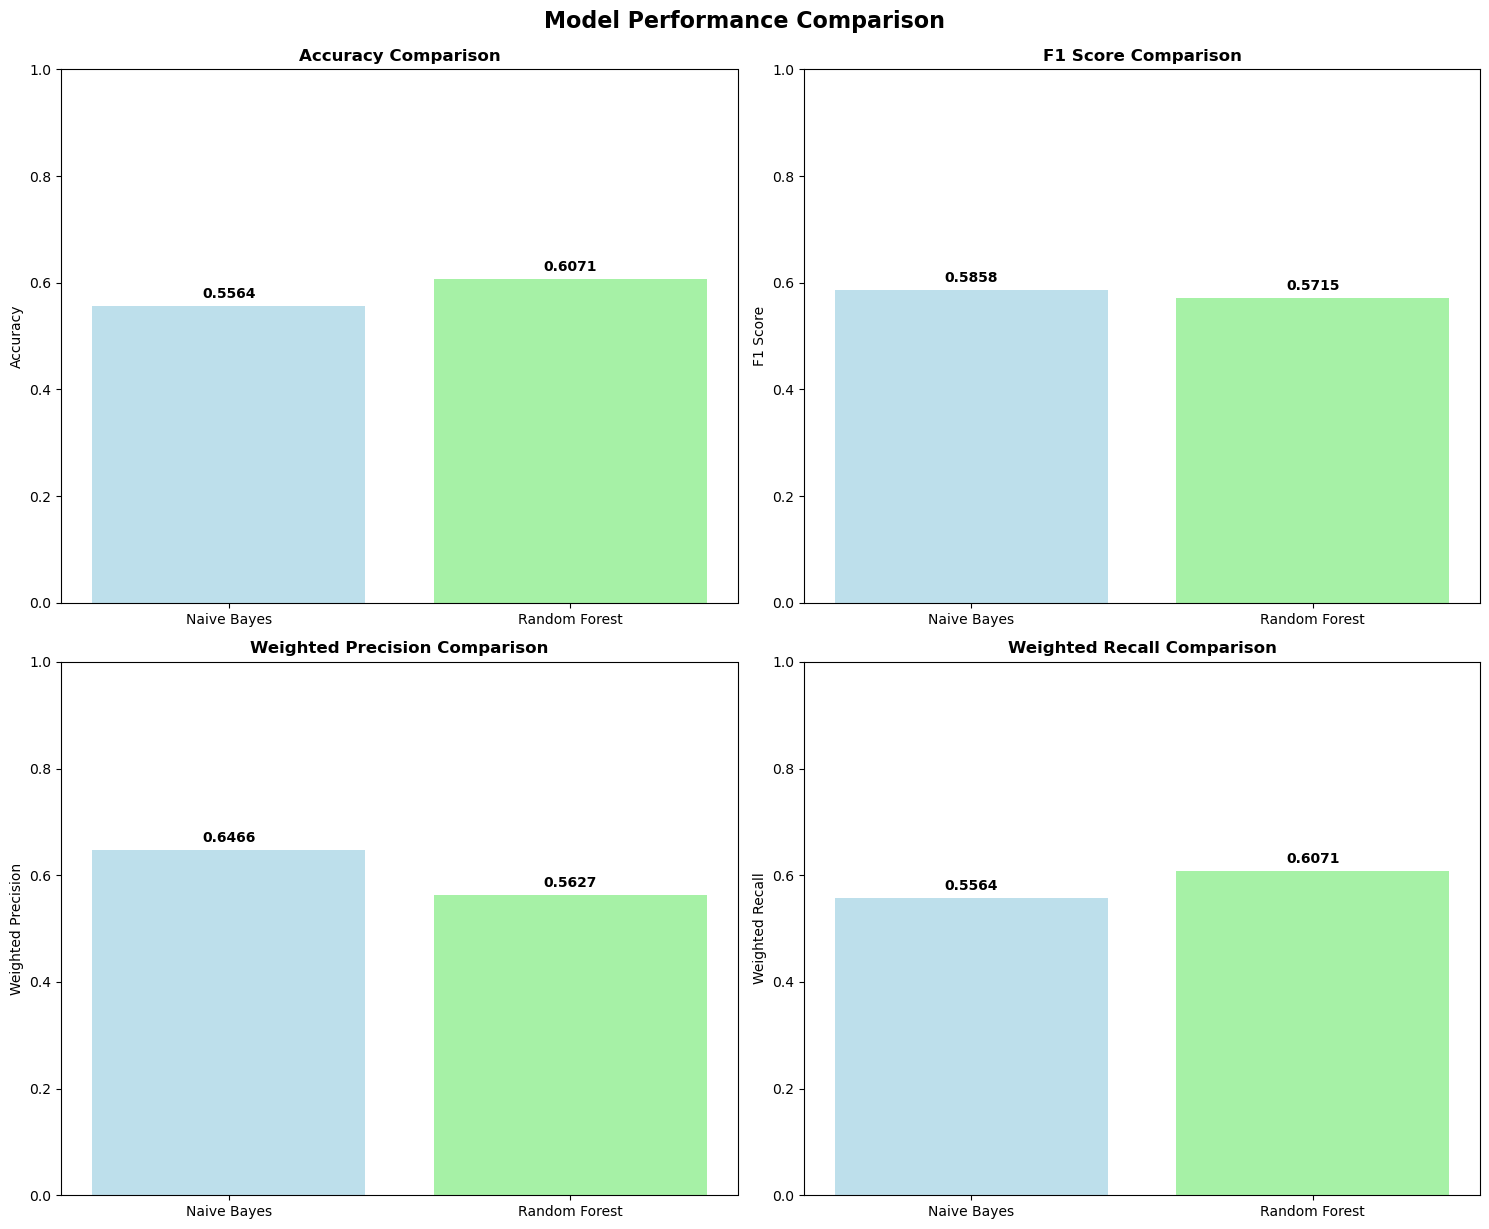


3. Best model: Naive Bayes (F1 score: 0.5858)


In [9]:
# Model Comparison and Evaluation Report
print("=== Model Comparison and Evaluation Report ===")

# 1. Model performance comparison
results_comparison = pd.DataFrame([nb_results, rf_results])
print("1. Model performance comparison:")
print(results_comparison.round(4))

# 2. Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['accuracy', 'f1', 'precision', 'recall']
metric_names = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    values = [nb_results[metric], rf_results[metric]]
    models = ['Naive Bayes', 'Random Forest']
    colors = ['lightblue', 'lightgreen']
    
    bars = ax.bar(models, values, color=colors, alpha=0.8)
    ax.set_title(f'{name} Comparison', fontweight='bold')
    ax.set_ylabel(name)
    ax.set_ylim(0, 1)
    
    # Add numerical labels on bar chart
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# 3. Determine best model
best_model_name = 'Naive Bayes' if nb_f1 > rf_f1 else 'Random Forest'
best_predictions = nb_predictions if nb_f1 > rf_f1 else rf_predictions
best_pred_col = 'nb_prediction' if nb_f1 > rf_f1 else 'rf_prediction'

print(f"\n3. Best model: {best_model_name} (F1 score: {max(nb_f1, rf_f1):.4f})")


=== Detailed Classification Report ===
Generating detailed report for best model (Naive Bayes):

1. Classification report:
              precision    recall  f1-score   support

    Negative       0.68      0.60      0.64     41253
     Neutral       0.19      0.51      0.28      9379
    Positive       0.72      0.52      0.60     40050

    accuracy                           0.56     90682
   macro avg       0.53      0.54      0.51     90682
weighted avg       0.65      0.56      0.59     90682

2. Confusion matrix:
[[24954  6232 10067]
 [ 8981 20743 10326]
 [ 2728  1892  4759]]


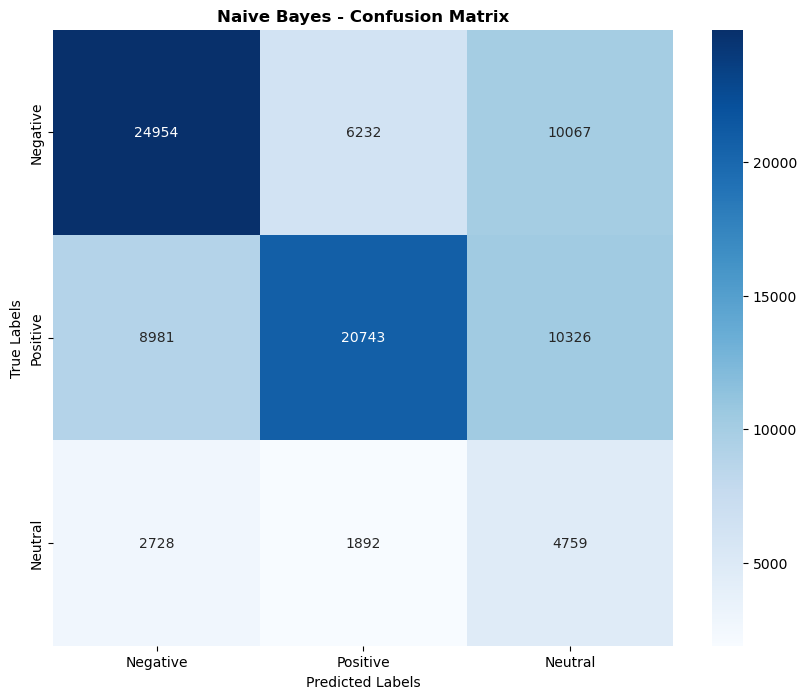


3. Performance analysis by class:
  Negative:
    Precision: 0.6806
    Recall: 0.6049
    F1 score: 0.6405
    Support (sample count): 41253
  Positive:
    Precision: 0.7186
    Recall: 0.5179
    F1 score: 0.6020
    Support (sample count): 40050
  Neutral:
    Precision: 0.1892
    Recall: 0.5074
    F1 score: 0.2756
    Support (sample count): 9379


In [10]:
# Detailed Classification Report and Confusion Matrix
print("=== Detailed Classification Report ===")

# 1. Generate confusion matrix data
def get_confusion_matrix_data(predictions, prediction_col):
    """Generate confusion matrix data"""
    # Collect prediction results
    results = predictions.select("label", prediction_col).collect()
    
    y_true = [row["label"] for row in results]
    y_pred = [row[prediction_col] for row in results]
    
    return y_true, y_pred

# 2. Generate detailed report for best model
print(f"Generating detailed report for best model ({best_model_name}):")

y_true, y_pred = get_confusion_matrix_data(best_predictions, best_pred_col)

# Convert numerical labels back to text labels
label_mapping = {i: label for i, label in enumerate(labels)}
y_true_labels = [label_mapping[int(label)] for label in y_true]
y_pred_labels = [label_mapping[int(pred)] for pred in y_pred]

# Generate classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\n1. Classification report:")
print(classification_report(y_true_labels, y_pred_labels, zero_division=0))

# 2. Confusion matrix
print("2. Confusion matrix:")
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=labels)
print(cm)

# 3. Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title(f'{best_model_name} - Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 4. Analyze performance by class
print("\n3. Performance analysis by class:")
for i, label in enumerate(labels):
    true_positives = cm[i, i]
    false_positives = sum(cm[:, i]) - true_positives
    false_negatives = sum(cm[i, :]) - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"  {label}:")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    F1 score: {f1:.4f}")
    print(f"    Support (sample count): {sum(cm[i, :])}")


In [11]:
# Save Model Evaluation Results
print("=== Saving Model Evaluation Results ===")

# 1. Create complete evaluation report
evaluation_report = {
    "experiment_info": {
        "dataset_size": df_filtered.count(),
        "train_size": train_count,
        "test_size": test_count,
        "feature_size": len(count_model.vocabulary),
        "num_classes": len(labels),
        "class_labels": labels
    },
    "models": {
        "naive_bayes": nb_results,
        "random_forest": rf_results
    },
    "best_model": {
        "name": best_model_name,
        "metrics": nb_results if best_model_name == 'Naive Bayes' else rf_results
    },
    "class_distribution": {
        "train": train_label_dist.toPandas().to_dict('records'),
        "test": test_label_dist.toPandas().to_dict('records')
    }
}

# 2. Save evaluation report
import json
report_path = "/home/jovyan/work/data/processed/classification_evaluation_report.json"

with open(report_path, 'w', encoding='utf-8') as f:
    json.dump(evaluation_report, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ Model evaluation report saved to: {report_path}")

# 3. Save best model prediction results (samples)
sample_predictions = best_predictions.select(
    "id", "cleaned_body", "sentiment_label", "label", best_pred_col
).limit(1000)

sample_path = "/home/jovyan/work/data/processed/classification_sample_predictions.parquet"
sample_predictions.write.mode("overwrite").parquet(sample_path)

print(f"✅ Sample prediction results saved to: {sample_path}")

# 4. Generate final summary
print("\n=== Classification Modeling Summary ===")
print(f"🎯 Experiment completion overview:")
print(f"   Dataset size: {df_filtered.count():,} records")
print(f"   Feature dimensions: {len(count_model.vocabulary):,}")
print(f"   Number of classes: {len(labels)}")
print(f"   Training set: {train_count:,} | Test set: {test_count:,}")

print(f"\n📊 Model performance comparison:")
print(f"   Naive Bayes    - Accuracy: {nb_accuracy:.4f} | F1: {nb_f1:.4f}")
print(f"   Random Forest  - Accuracy: {rf_accuracy:.4f} | F1: {rf_f1:.4f}")

print(f"\n🏆 Best model: {best_model_name}")
best_metrics = nb_results if best_model_name == 'Naive Bayes' else rf_results
print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   F1 score: {best_metrics['f1']:.4f}")
print(f"   Precision: {best_metrics['precision']:.4f}")
print(f"   Recall: {best_metrics['recall']:.4f}")

print(f"\n💡 Results analysis:")
if best_metrics['accuracy'] > 0.7:
    print("   ✅ Model performance is good, can distinguish sentiment classes well")
elif best_metrics['accuracy'] > 0.6:
    print("   ⚠️ Model performance is moderate, room for improvement")
else:
    print("   ❌ Model performance is low, suggest adjusting features or algorithms")

print(f"\n🔧 Improvement suggestions:")
print("   1. Can try more feature engineering (such as N-gram, word vectors, etc.)")
print("   2. Adjust model hyperparameters for optimization")
print("   3. Consider ensemble learning methods")
print("   4. Add more preprocessing steps")

print("\n=== Classification modeling experiment completed! ===")


=== Saving Model Evaluation Results ===
✅ Model evaluation report saved to: /home/jovyan/work/data/processed/classification_evaluation_report.json
✅ Sample prediction results saved to: /home/jovyan/work/data/processed/classification_sample_predictions.parquet

=== Classification Modeling Summary ===
🎯 Experiment completion overview:
   Dataset size: 454,264 records
   Feature dimensions: 3,000
   Number of classes: 3
   Training set: 363,582 | Test set: 90,682

📊 Model performance comparison:
   Naive Bayes    - Accuracy: 0.5564 | F1: 0.5858
   Random Forest  - Accuracy: 0.6071 | F1: 0.5715

🏆 Best model: Naive Bayes
   Accuracy: 0.5564
   F1 score: 0.5858
   Precision: 0.6466
   Recall: 0.5564

💡 Results analysis:
   ❌ Model performance is low, suggest adjusting features or algorithms

🔧 Improvement suggestions:
   1. Can try more feature engineering (such as N-gram, word vectors, etc.)
   2. Adjust model hyperparameters for optimization
   3. Consider ensemble learning methods
   4. 